In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from lgca import get_lgca
from tqdm.auto import tqdm
from plot_funcs import label_axes

In [2]:
plt.style.use('default')
plt.style.use('thesis_style.mplstyle') # only activate for thesis, adjust height

In [3]:
files = [f'lgca_gamma{gamma}_rep{rep}.pkl' for gamma in [0, 8, 16] for rep in range(4)]

In [4]:
skip = 1

In [5]:
densities = []
mean_props = []
spatial_extend = []

for i, file in tqdm(enumerate(files[::-1]), total=len(files)):
    with open(file, 'rb') as f:
        lgca = pkl.load(f)

    tmax = len(lgca.dens_t)
    densities.append(lgca.dens_t[::skip])
    prop = np.array(lgca.props['r_b'])
    cells_t = lgca.nodes_t[::skip].sum((1,2))

    # print([[cells if not isinstance(cells, list)  for cells in cells_t[t]] for t in range(tmax)])
    # prop_t = [[prop[cells] if len(cells) > 0 else np.array([np.nan]) for cells in cells_t[t]] for t in range(tmax)]
    prop_t = [prop[cells] if len(cells) > 0 else np.nan for cells in cells_t]
    mean_prop_t = np.array([np.mean(prop) for prop in prop_t])
        

    # mean_prop_t = np.array([[np.mean(prop) if prop.size > 0 else np.nan for prop in prop_t[t]] for t in range(tmax)])
    spatial_extend_t = lgca.dens_t[::skip].astype(bool).sum(-1)
    # std_mean_prop_t = np.array(
    #     [[np.std(prop, ddof=1, axis=-1) if len(prop) > 1 else np.nan for prop in prop_t[t]] for t in range(tmax)])
    mean_props.append(mean_prop_t)
    spatial_extend.append(spatial_extend_t)
    # std_mean_props.append(std_mean_prop_t)

  0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
K = lgca.interaction_params['capacity']
r_d = lgca.interaction_params['r_d']
r_b = lgca.interaction_params['r_b']
p_p = lgca.interaction_params['p_p']
p_d = lgca.interaction_params['p_d']
s_p = lgca.interaction_params['s_p']
s_d = lgca.interaction_params['s_d']
Ncrit = (p_p * r_b * s_p) / (p_d * s_d**2)
Lmax = lgca.dens_t.shape[-1]
dens0 = 1 - r_d / r_b



In [7]:
lgca.interaction_params

{'capacity': 179,
 'r_b': 0.5,
 'r_d': 0.375,
 'p_d': 7e-06,
 'p_p': 0.05,
 's_d': 0.1,
 's_p': 0.0005,
 'a_max': 1,
 'gamma': 0}

In [8]:
# skip=100
tmax = len(lgca.dens_t)
x = np.arange(tmax) * r_b * (1 - dens0)
nshow = 401
# x += 1

In [9]:
def log_sample_indices(arr_length, n_samples):
    max_idx = arr_length - 1
    log_indices = np.logspace(0, np.log10(max_idx), n_samples)
    rounded_indices = np.unique(np.round(log_indices).astype(int))
    return rounded_indices

In [10]:
indices = log_sample_indices(tmax, nshow)
x = x[indices]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


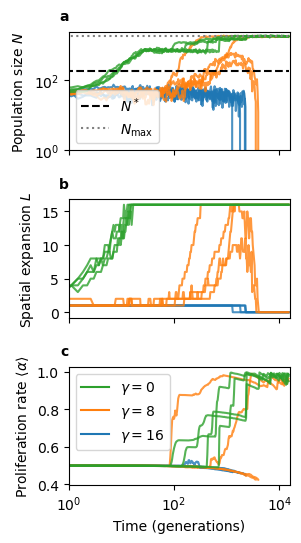

In [26]:
golden_ratio = (np.sqrt(5) + 1.0) / 2.0
# get default figsize
wi, le = plt.rcParams['figure.figsize']
wi = 0.5 * wi
le = 5.5

fig, ax = plt.subplots(3, 1, sharey=False, sharex=True, figsize=(wi, le))

plt.sca(ax[0])

Nmax = K * (1 - r_d) * Lmax
for i, density in enumerate(densities):
    plt.plot(x, density[indices].sum(1), c='C{}'.format(i // 4), alpha=.8)

plt.yscale('log')
plt.ylim(1, 1.3*Nmax)
plt.plot([0, x[-1]], [Ncrit, Ncrit], 'k--', label='$N^*$')
plt.plot([0, x[-1]], [Nmax, Nmax], ':', c='gray', label=r'$N_{\max}$')
plt.legend(loc='lower left')
t_d = (r_b - r_d) / (r_d * p_p * s_p)
t_d *= r_b * (1 - dens0)
t_rescue = 236 * r_b * (1 - dens0)
# plt.plot([t_d, t_d], [0, Nmax], 'r--')
# plt.plot([t_rescue, t_rescue], [0, Nmax], 'g--')


plt.ylabel('Population size $N$')

plt.sca(ax[1])
for i, extend in enumerate(spatial_extend):
    plt.plot(x, extend[indices], c='C{}'.format(i // 4), alpha=.8)
    
plt.ylabel('Spatial expansion $L$')
# ts = x / r_b / (1 - dens0)
# r_bt = r_b - r_d * p_p * s_p * ts
# r_bt[r_bt <= r_d] = np.nan
# for i, gamma in enumerate([0, 8, 16][::-1]):
#     D = 1 / (2 + np.exp(gamma))
#     v = 2 * np.sqrt((r_bt - r_d) * D)
#     plt.plot(x, np.minimum(v * ts + 1, Lmax), '--', c='C{}'.format(i)) 
# gamma = 8
# D = 1 / (2 + np.exp(gamma))

# v = 2 * np.sqrt((r_bt - r_d) * D)
# plt.plot(x, np.minimum(v * ts + 1, Lmax), '--')

plt.sca(ax[-1])
    
for i, alpha in enumerate(mean_props):
    plt.plot(x, alpha[indices], c='C{}'.format(i // 4), alpha=.8)

# plt.plot(x, r_bt, '--', c='gray', alpha=.8)
plt.ylabel(r'Proliferation rate $\langle\alpha\rangle$')
# 
plt.xlabel('Time (generations)')

# create a function to format the y axis labels
# def format_y_ticks(tick_val, pos):
#     return f'{tick_val * 10**2 :.1f}'
# 
# # apply the formatter
# ax[-1].yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
# 
# # Add scale next to the y-axis
# ax[-1].text(-0.1, 1.0, r'$\times 10^{-2}$', transform=ax[-1].transAxes, fontsize='small')
# ax[-1].set_yticks([0.0, 0.1, 0.2])
# ax[-1].set_xticks([0, 5000, 10000], [0, 5, 10])
# ax[-1].text(1.0, -0.05, r'$\times 10^{3}$', transform=ax[-1].transAxes, fontsize='small')
leg = plt.legend()
lines, labels = plt.gca().get_legend_handles_labels()
lines += [plt.Line2D([0], [0], c=c) for c in ['C0', 'C1', 'C2'][::-1]]
labels += ['$\gamma = 0$', '$\gamma = 8$', '$\gamma=16$']
plt.plot([])
plt.legend(lines, labels, loc='best')
plt.xlim(1)
# plt.ylim(0, 0.02)
label_axes(ax, usetex=False)
plt.tight_layout()
plt.xscale('log')
plt.savefig('mullersratchet_N_nostd_spatial.pdf')

In [12]:
r_d

0.375